<a href="https://colab.research.google.com/github/atilaye/GMG-MAAI-Training-ML-LanguageModels/blob/main/GMG_MAAI_Training_ML_LanguageModels_(Quiz_1).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Install Required Packages

In [ ]:
! pip install datasets transformers==4.40.0 accelerate

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 137.6/137.6 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.0/9.0 MB 51.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 527.3/527.3 kB 30.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 9.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.9/39.9 MB 11.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 10.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 9.4 MB/s eta 0:00:00
  Attempting uninstall: pyarrow
    Found existing installation: pyarrow 14.0.2
    Uninstalling pyarrow-14.0.2:
      Successfully uninstalled pyarrow-14.0.2
  Attempting uninstall: transformers
    Found existing installation: transformers 4.42.4
    Uninstalling transformers-4.42.4:
      Successfully uninstalled transformers-4.42.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are instal

In [ ]:
import transformers

print(transformers.__version__)

4.42.4


# Train a language model

Causal language modeling: the model has to predict the next token in the sentence (so the labels are the same as the inputs shifted to the right). To make sure the model does not cheat, it gets an attention mask that will prevent it to access the tokens after token `i` when trying to predict the token `i+1` in the sentence.


## Preparing the dataset

We will use the `Wikitext 2` dataset as an example. You can load it very easily with the 'datasets' library and use with any dataset hosted on [Huggingface Datasets](https://huggingface.co/datasets) or use your own files.

In [ ]:
from datasets import load_dataset
datasets = load_dataset('wikitext', 'wikitext-2-raw-v1')

To access an actual element, you need to select a split first, then give an index:

In [ ]:
datasets["train"][10]

To get a sense of what the data looks like, the following function will show some examples picked randomly in the dataset.

In [ ]:
from datasets import ClassLabel
import random
import pandas as pd
import time
from IPython.display import display, HTML

def show_random_elements(dataset, num_examples=10):
    assert num_examples <= len(dataset), "Can't pick more elements than there are in the dataset."
    picks = []
    for _ in range(num_examples):
        pick = random.randint(0, len(dataset)-1)
        while pick in picks:
            pick = random.randint(0, len(dataset)-1)
        picks.append(pick)

    df = pd.DataFrame(dataset[picks])
    for column, typ in dataset.features.items():
        if isinstance(typ, ClassLabel):
            df[column] = df[column].transform(lambda i: typ.names[i])
    display(HTML(df.to_html()))

In [ ]:
show_random_elements(datasets["train"])

As we can see, some of the texts are a full paragraph of a Wikipedia article while others are just titles or empty lines.

## Causal Language modeling

For causal language modeling (CLM) we are going to take all the texts in our dataset and concatenate them after they are tokenized. Then we will split them in examples of a certain sequence length. This way the model will receive chunks of contiguous text that may look like:
```
part of text 1
```
or
```
end of text 1 [BOS_TOKEN] beginning of text 2
```
depending on whether they span over several of the original texts in the dataset or not. The labels will be the same as the inputs, shifted to the left.

We will use the [`gpt2`](https://huggingface.co/gpt2) architecture for this example. You can pick any of the checkpoints listed [here](https://huggingface.co/models?filter=causal-lm) instead. For the tokenizer, you can replace the checkpoint by the one you trained yourself.

In [ ]:
model_checkpoint = "gpt2"
tokenizer_checkpoint = "sgugger/gpt2-like-tokenizer"

To tokenize all our texts with the same vocabulary that was used when training the model, we have to download a pretrained tokenizer. This is all done by the `AutoTokenizer` class:

In [ ]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained(tokenizer_checkpoint)

We can now call the tokenizer on all our texts. This is very simple, using the [`map`](https://huggingface.co/docs/datasets/package_reference/main_classes.html#datasets.Dataset.map) method from the Datasets library. First we define a function that call the tokenizer on our texts:

In [ ]:
def tokenize_function(examples):
    return tokenizer(examples["text"])

Then we apply it to all the splits in our `datasets` object, using `batched=True` and 4 processes to speed up the preprocessing. We won't need the `text` column afterward, so we discard it.

In [ ]:

tokenized_datasets = datasets.map(tokenize_function, batched=True, num_proc=4, remove_columns=["text"])

If we now look at an element of our datasets, we will see the text have been replaced by the `input_ids` the model will need:

In [ ]:
tokenized_datasets["train"][1]

Now for the harder part: we need to concatenate all our texts together then split the result in small chunks of a certain `block_size`. To do this, we will use the `map` method again, with the option `batched=True`. This option actually lets us change the number of examples in the datasets by returning a different number of examples than we got. This way, we can create our new samples from a batch of examples.

First, we grab the maximum length our model was pretrained with. This might be a big too big to fit in your GPU RAM, so here we take a bit less at just 128.

In [ ]:
# block_size = tokenizer.model_max_length
block_size = 128

Then we write the preprocessing function that will group our texts:

In [ ]:
def group_texts(examples):
    # Concatenate all texts.
    concatenated_examples = {k: sum(examples[k], []) for k in examples.keys()}
    total_length = len(concatenated_examples[list(examples.keys())[0]])
    # We drop the small remainder, we could add padding if the model supported it instead of this drop, you can
        # customize this part to your needs.
    total_length = (total_length // block_size) * block_size
    # Split by chunks of max_len.
    result = {
        k: [t[i : i + block_size] for i in range(0, total_length, block_size)]
        for k, t in concatenated_examples.items()
    }
    result["labels"] = result["input_ids"].copy()
    return result

First note that we duplicate the inputs for our labels. This is because the model of the 🤗 Transformers library apply the shifting to the right, so we don't need to do it manually.

Also note that by default, the `map` method will send a batch of 1,000 examples to be treated by the preprocessing function. So here, we will drop the remainder to make the concatenated tokenized texts a multiple of `block_size` every 1,000 examples. You can adjust this behavior by passing a higher batch size (which will also be processed slower). You can also speed-up the preprocessing by using multiprocessing:

In [ ]:
lm_datasets = tokenized_datasets.map(
    group_texts,
    batched=True,
    batch_size=1000,
    num_proc=4,
)

And we can check our datasets have changed: now the samples contain chunks of `block_size` contiguous tokens, potentially spanning over several of our original texts.

In [ ]:
tokenizer.decode(lm_datasets["train"][1]["input_ids"])

Now that the data has been cleaned, we're ready to instantiate our `Trainer`. First we create the model using the same config as our checkpoint, but initialized with random weights:

In [ ]:
from transformers import AutoConfig, AutoModelForCausalLM

config = AutoConfig.from_pretrained(model_checkpoint)
model = AutoModelForCausalLM.from_config(config)

And we will needsome `TrainingArguments`:

In [ ]:
from transformers import Trainer, TrainingArguments

In [ ]:
print(f"{model_checkpoint}-wikitext2")

In [ ]:
training_args = TrainingArguments(
    f"{model_checkpoint}-wikitext2",
    evaluation_strategy = "epoch",
    num_train_epochs=2,
    learning_rate=2e-5,
    weight_decay=0.01,
    push_to_hub=False
)

In [ ]:
def pre_process( dataset, take_percent = 1):
    totalSamples = len(dataset)
    print(f"Using {take_percent}% of total {totalSamples} samples" )
    return (dataset.select(range(int((take_percent/100)*totalSamples))))



We pass along all of those to the `Trainer` class:

In [ ]:
take_percent = 10
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset= pre_process( lm_datasets["train"], take_percent=take_percent) ,
    eval_dataset=pre_process( lm_datasets["validation"], take_percent=take_percent)
)

In [ ]:
import time
import math

And we can train our model:

In [ ]:
start_time = time.time()
trainer.train()
training_runtime = time.time() - start_time
print("Training completed in (seconds) : ", training_runtime)

In [ ]:
eval_results = trainer.evaluate()
print(f"Cross-Entropy Loss: {eval_results['eval_loss']:.2f}")
print(f"Perplexity Loss: {math.exp(eval_results['eval_loss']):.2f}")

For More Details:
1. https://huggingface.co/docs/transformers/v4.40.0/en/main_classes/pipelines#transformers.TextGenerationPipeline
2. https://huggingface.co/docs/transformers/main/en/model_doc/auto#transformers.AutoModelForCausalLM

#**Quiz**

#**Quiz**

Submit the answers to the quesetions on this google form: https://forms.gle/AnQwnrRt4tPY6szY7

## 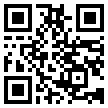


1. Get Training Times for 10% , 20%, 30% of datasets without changing any other parameters. Your 100% dataset has approximately 2 million words, Meta has recently reported using a dataset of approx 11.5 trillion words. How much training time would it take to train your model with Meta's dataset? Assume you would use the same hardware, same model, and same parameters as your current notebook.   
Hint: change `num_train_epochs` in  `training_args`


In [ ]:
from datasets import load_dataset
datasets = load_dataset('wikitext', 'wikitext-2-raw-v1')
model_checkpoint = "gpt2"
tokenizer_checkpoint = "sgugger/gpt2-like-tokenizer"
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained(tokenizer_checkpoint)
def tokenize_function(examples):
    return tokenizer(examples["text"])
tokenized_datasets = datasets.map(tokenize_function, batched=True, num_proc=4, remove_columns=["text"])
# block_size = tokenizer.model_max_length
block_size = 128


def group_texts(examples):
    # Concatenate all texts.
    concatenated_examples = {k: sum(examples[k], []) for k in examples.keys()}
    total_length = len(concatenated_examples[list(examples.keys())[0]])
    # We drop the small remainder, we could add padding if the model supported it instead of this drop, you can
        # customize this part to your needs.
    total_length = (total_length // block_size) * block_size
    # Split by chunks of max_len.
    result = {
        k: [t[i : i + block_size] for i in range(0, total_length, block_size)]
        for k, t in concatenated_examples.items()
    }
    result["labels"] = result["input_ids"].copy()
    return result

lm_datasets = tokenized_datasets.map(
    group_texts,
    batched=True,
    batch_size=11500000000000,
    num_proc=4,
)
from transformers import Trainer, TrainingArguments
training_args = TrainingArguments(
    f"{model_checkpoint}-wikitext2", #wikitext2
    evaluation_strategy = "epoch",
    num_train_epochs=10,
    learning_rate=2e-5,
    weight_decay=0.01,
    push_to_hub=False
)
def pre_process( dataset, take_percent = 1):
    totalSamples = len(dataset)
    print(f"Using {take_percent}% of total {totalSamples} samples" )
    return (dataset.select(range(int((take_percent/100)*totalSamples))))



In [ ]:
take_percent = 10
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset= pre_process( lm_datasets["train"], take_percent=take_percent) ,
    eval_dataset=pre_process( lm_datasets["validation"], take_percent=take_percent)
)
start_time = time.time()
trainer.train()
training_runtime = time.time() - start_time
print("Training completed in (seconds) : ", training_runtime)

In [ ]:
take_percent = 20
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset= pre_process( lm_datasets["train"], take_percent=take_percent) ,
    eval_dataset=pre_process( lm_datasets["validation"], take_percent=take_percent)
)
start_time = time.time()
trainer.train()
training_runtime = time.time() - start_time
print("Training completed in (seconds) : ", training_runtime)

In [ ]:
take_percent = 30
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset= pre_process( lm_datasets["train"], take_percent=take_percent) ,
    eval_dataset=pre_process( lm_datasets["validation"], take_percent=take_percent)
)
start_time = time.time()
trainer.train()
training_runtime = time.time() - start_time
print("Training completed in (seconds) : ", training_runtime)

2. Get Cross-Entropy Loss values for 1, 3, 5 epochs and using 1% of dataset without changing any other parameters. How many epochs would it take to get Cross-Entropy Loss of 3 ?  
Hint: change `take_percent` in  `Trainer`

In [ ]:
lm_datasets = tokenized_datasets.map(
    group_texts,
    batched=True,
    batch_size=1000,
    num_proc=4,
)
from transformers import Trainer, TrainingArguments
training_args = TrainingArguments(
    f"{model_checkpoint}-wikitext2",
    evaluation_strategy = "epoch",
    num_train_epochs=1,
    learning_rate=2e-5,
    weight_decay=0.01,
    push_to_hub=False
)
def pre_process( dataset, take_percent = 1):
    totalSamples = len(dataset)
    print(f"Using {take_percent}% of total {totalSamples} samples" )
    return (dataset.select(range(int((take_percent/100)*totalSamples))))

take_percent = 1
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset= pre_process( lm_datasets["train"], take_percent=take_percent) ,
    eval_dataset=pre_process( lm_datasets["validation"], take_percent=take_percent)
)
import time
import math

start_time = time.time()
trainer.train()
training_runtime = time.time() - start_time
print("Training completed in (seconds) : ", training_runtime)
eval_results = trainer.evaluate()
print(f"Cross-Entropy Loss: {eval_results['eval_loss']:.2f}")
print(f"Perplexity Loss: {math.exp(eval_results['eval_loss']):.2f}")

3. How would you compare the accuracy of a model which generated text "This is a white dog " but the expected text was "This is a green dog" ?



In [ ]:
# prompt: Find the accuracy of a model generating the text "This is a white dog" but the expected text was "This is a green dog"

# Calculate the accuracy based on the number of matching words.
generated_text = "This is a white dog"
expected_text = "This is a green dog"

generated_words = generated_text.split()
expected_words = expected_text.split()

matching_words = sum(1 for i in range(min(len(generated_words), len(expected_words))) if generated_words[i] == expected_words[i])
accuracy = matching_words / len(expected_words)

print(f"Accuracy: {accuracy:.2f}")
